In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [181]:
df = pd.read_csv('data/cbdns-1.csv')
df.columns

Index([u'datestr', u'mega_region', u'marketplace', u'token_type', u'cb_1d_amt',
       u'cb_7d_amt', u'cb_14d_amt', u'cb_21d_amt', u'cb_28d_amt',
       u'dns_1d_amt', u'dns_7d_amt', u'dns_14d_amt', u'dns_21d_amt',
       u'dns_28d_amt'],
      dtype='object')

In [182]:
data = df.copy()
metric = 'dns_1d_amt'
date = 'datestr'
data = data[(data[date] <= '2018-10-12')]
incident = data[
    (1 == 1)
    & (data['mega_region'] == 'India SA')
#     & (data['auth_state'] == 'VOIDED')
#     & (data['sub_marketplace'] == 'Not_Avlbl')
#     & (data['marketplace'] == 'agora')
#     & (data['psp_name'] == 'other')
].groupby([date], as_index= False)[metric].sum()


incident[date] = pd.to_datetime(incident[date])
incident = incident.set_index(date)
# pending
series = incident[metric]
series = series.drop([series[:-1].idxmax(),series[:-1].idxmin()])
# series

In [201]:
config_object={'iqr_multiplier':2, 'sd_threshold_anomaly':2.5}
def anomaly_criteria_custom1(current_series, config_object, logging):

    # Create a copy of the original series
    original_series = current_series.copy()

    # logging.info(current_series)
    if not current_series.isnull().values.any():
        # Get seasonality decomoposition to remove the seasonal variation (7 days here)
        seasonality_decomp = seasonal_decompose(current_series, model='additive', freq=7)
        # Get the seasonal variation out
        current_series = seasonality_decomp.observed - seasonality_decomp.seasonal

    len_series = len(current_series)

    # Interquartile Range method for anomaly
    temp_q_25 = current_series[0:-1].quantile(0.25)
    temp_q_75 = current_series[0:-1].quantile(0.75)
    iqr = temp_q_75 - temp_q_25
    alarm_threshold_up = temp_q_75 + (iqr * config_object['iqr_multiplier'])
    alarm_threshold_down = temp_q_25 - (iqr * config_object['iqr_multiplier'])

    # If the latest value in the series is an anomaly
    # For each methodology, error check if the denominator is 0, then return False (We don't consider such edge cases as the distribution is very bad)
    # RETURN VALUE: if anomaly, returns a factor that depicts the extent of anomalyness | if not, returns False
    if (current_series[len_series - 1] > alarm_threshold_up) or (current_series[len_series - 1] < alarm_threshold_down):
        if iqr == 0:
            return False
        # Custom check to make sure that the num_trips in the bucket > 10000 to remove false positives
        elif abs(original_series[len_series - 1] - original_series[0:-1].median()) < 10000:
            return False
        # Custom check to make sure that the percnt change since last median is more than 50 percent
        elif (((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 < 40.0) and
                ((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 > -40.0)):
            return False
        else:
#             logging.info(current_series)
#             logging.info((current_series[len_series - 1] / float(current_series[0:-1].median()) - 1) * 100)
            return abs(current_series[len_series - 1] - current_series.median()) / float(iqr)
    else:
        return False

def anomaly_criteria_custom2(current_series, config_object, logging):

    # Create a copy of the original series
    original_series = current_series.copy()

    # logging.info(current_series)
    if not current_series.isnull().values.any():
        # Get seasonality decomoposition to remove the seasonal variation (7 days here)
        seasonality_decomp = seasonal_decompose(current_series, model='additive', freq=7)
        # Get the seasonal variation out
        current_series = seasonality_decomp.observed - seasonality_decomp.seasonal

    len_series = len(current_series)

    # Interquartile Range method for anomaly
    # temp_q_25 = current_series[0:-1].quantile(0.25)
    # temp_q_75 = current_series[0:-1].quantile(0.75)
    # iqr = temp_q_75 - temp_q_25
    # alarm_threshold_up = temp_q_75 + (iqr * 3)
    # alarm_threshold_down = temp_q_25 - (iqr * 3)

    temp_sd = current_series[:-1].std()
    temp_mean = current_series[:-1].mean()
    alarm_threshold_up = temp_mean + 3 * temp_sd
    alarm_threshold_down = temp_mean - 3 * temp_sd
    
    print '~~~~~Debug~~~~~'
    print 'Up: ' + str(alarm_threshold_up)
    print 'Current: ' + str(current_series[-1])
    print 'From Graph: ' + str(current_series[:-1].mean() + 2.5*current_series[:-1].std())
#     print current_series

    # If the latest value in the series is an anomaly
    # For each methodology, error check if the denominator is 0, then return False (We don't consider such edge cases as the distribution is very bad)
    # RETURN VALUE: if anomaly, returns a factor that depicts the extent of anomalyness | if not, returns False
    if (current_series[len_series - 1] > alarm_threshold_up) or (current_series[len_series - 1] < alarm_threshold_down):
        if temp_sd == 0:
            return False
        # Custom check to make sure that the num_trips in the bucket > 10000 to remove false positives
        elif abs(original_series[len_series - 1] - original_series[0:-1].median()) < 10000:
            return False
        # Custom check to make sure that the percnt change since last median is more than 50 percent
        elif (((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 < 40.0) and
                ((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 > -40.0)):
            return False
        else:
#             logging.info(current_series)
#             logging.info((current_series[len_series - 1] / float(current_series[0:-1].median()) - 1) * 100)
            return abs(current_series[len_series - 1] - current_series.median()) / float(temp_sd)
    else:
        return False
    
# def anomaly_criteria_custom3(current_series, config_object, logging):

#     # Create a copy of the original series
#     original_series = current_series.copy()

#     # logging.info(current_series)
# #     if not current_series.isnull().values.any():
# #         # Get seasonality decomoposition to remove the seasonal variation (7 days here)
# #         seasonality_decomp = seasonal_decompose(current_series, model='additive', freq=7)
# #         # Get the seasonal variation out
# #         current_series = seasonality_decomp.observed - seasonality_decomp.seasonal

#     len_series = len(current_series)

#     # Interquartile Range method for anomaly
#     # temp_q_25 = current_series[0:-1].quantile(0.25)
#     # temp_q_75 = current_series[0:-1].quantile(0.75)
#     # iqr = temp_q_75 - temp_q_25
#     # alarm_threshold_up = temp_q_75 + (iqr * 3)
#     # alarm_threshold_down = temp_q_25 - (iqr * 3)

#     temp_sd = current_series[0:-1].std()
#     temp_mean = current_series[0:-1].mean()
#     alarm_threshold_up = temp_mean + config_object['sd_threshold_anomaly'] * temp_sd
#     alarm_threshold_down = temp_mean - config_object['sd_threshold_anomaly'] * temp_sd

#     print '~~~~~Debug~~~~~'
#     print 'Up: ' + str(alarm_threshold_up)
#     print 'Current: ' + str(current_series[-1])
#     print 'From Graph: ' + str(current_series[:-1].mean() + 2.5*current_series[:-1].std())
    
#     # If the latest value in the series is an anomaly
#     # For each methodology, error check if the denominator is 0, then return False (We don't consider such edge cases as the distribution is very bad)
#     # RETURN VALUE: if anomaly, returns a factor that depicts the extent of anomalyness | if not, returns False
#     if (current_series[len_series - 1] > alarm_threshold_up) or (current_series[len_series - 1] < alarm_threshold_down):
#         if temp_sd == 0:
#             return False
#         # Custom check to make sure that the num_trips in the bucket > 10000 to remove false positives
#         elif abs(original_series[len_series - 1] - original_series[0:-1].median()) < 10000:
#             return False
#         # Custom check to make sure that the percnt change since last median is more than 50 percent
#         elif (((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 < 40.0) and
#                 ((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 > -40.0)):
#             return False
#         else:
# #             logging.info(current_series)
# #             logging.info((current_series[len_series - 1] / float(current_series[0:-1].median()) - 1) * 100)
#             return abs(current_series[len_series - 1] - current_series.median()) / float(temp_sd)
#     else:
#         return False

def anomaly_criteria_custom3(current_series, config_object, logging):

    # Remove one anomalous point from the series (not the latest one)
    current_series = current_series.drop(current_series[:-1].idxmax())

    # Create a copy of the original series
    original_series = current_series.copy()

    # logging.info(current_series)
    # if not current_series.isnull().values.any():
    #     # Get seasonality decomoposition to remove the seasonal variation (7 days here)
    #     seasonality_decomp = seasonal_decompose(current_series, model='additive', freq=7)
    #     # Get the seasonal variation out
    #     current_series = seasonality_decomp.observed - seasonality_decomp.seasonal

    len_series = len(current_series)

    # Interquartile Range method for anomaly
    # temp_q_25 = current_series[0:-1].quantile(0.25)
    # temp_q_75 = current_series[0:-1].quantile(0.75)
    # iqr = temp_q_75 - temp_q_25
    # alarm_threshold_up = temp_q_75 + (iqr * 3)
    # alarm_threshold_down = temp_q_25 - (iqr * 3)

    temp_sd = current_series[0:-1].std()
    temp_mean = current_series[0:-1].mean()
    alarm_threshold_up = temp_mean + config_object['sd_threshold_anomaly'] * temp_sd
    alarm_threshold_down = temp_mean - config_object['sd_threshold_anomaly'] * temp_sd

    
    
    print '~~~~~Debug~~~~~'
    print 'Up: ' + str(alarm_threshold_up)
    print 'Current: ' + str(current_series[-1])
    print 'From Graph: ' + str(current_series[:-1].mean() + 2.5*current_series[:-1].std())

    
    # If the latest value in the series is an anomaly
    # For each methodology, error check if the denominator is 0, then return False (We don't consider such edge cases as the distribution is very bad)
    # RETURN VALUE: if anomaly, returns a factor that depicts the extent of anomalyness | if not, returns False
    if (current_series[len_series - 1] > alarm_threshold_up) or (current_series[len_series - 1] < alarm_threshold_down):
        if temp_sd == 0:
            return False
        # Custom check to make sure that the num_trips in the bucket > 10000 to remove false positives
        elif abs(original_series[len_series - 1] - original_series[0:-1].median()) < 10000:
            return False
        # Custom check to make sure that the percnt change since last median is more than 50 percent
        elif (((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 < 40.0) and
                ((original_series[len_series - 1] / float(original_series[0:-1].median()) - 1) * 100 > -40.0)):
            return False
        else:
#             logging.info(current_series)
#             logging.info((current_series[len_series - 1] / float(current_series[0:-1].median()) - 1) * 100)
            return abs(current_series[len_series - 1] - current_series.median()) / float(temp_sd)
    else:
        return False

In [217]:
# anomaly_criteria_custom1(series, config_object, "")
# print anomaly_criteria_custom3(series, config_object, "")
# print series[:-1].mean() + 2.5*series[:-1].std()
series1 = series.drop(series[:-1].idxmax(), axis = 0)
series1.max()

317477.74976460234

In [203]:
# result = seasonal_decompose(series, model='additive', freq=7)
# plt.subplot(2,2,1)
# plt.plot(result.observed)
# plt.subplot(2,2,2)
# plt.plot(result.seasonal)
# plt.subplot(2,2,3)
# plt.plot(result.observed - result.seasonal)
# plt.show()
temp_q_25 = series[0:-1].quantile(0.25)
temp_q_75 = series[0:-1].quantile(0.75)
iqr = temp_q_75 - temp_q_25
alarm_threshold_up = temp_q_75 + (iqr * 1)
alarm_threshold_down = temp_q_25 - (iqr * 1)

In [204]:
series[:-1].idxmax()
series2 = series.drop(series[:-1].idxmax())
series2[:-1].idxmax()

Timestamp('2018-10-06 00:00:00')

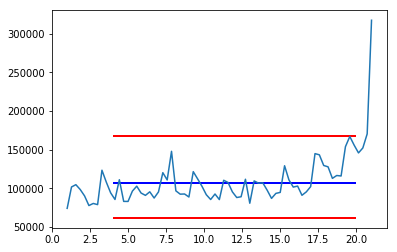

In [205]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 21, len(series))
y = series

fig, ax = plt.subplots()
ax.plot(x, y)
# ax.hlines(y=series[:-1].mean() + 3.5*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='r')
# ax.hlines(y=series[:-1].mean() - 3.5*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='r')
ax.hlines(y=series[:-1].mean() + 2.75*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='r')
ax.hlines(y=series[:-1].mean() - 2*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='r')
# ax.hlines(y=series[:-1].median() + 2.5*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='g')
# ax.hlines(y=series[:-1].median() - 2*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='g')
# ax.hlines(y=series[:-1].median() + 1*iqr, xmin=4, xmax=20, linewidth=2, color='y')
# ax.hlines(y=series[:-1].median() - 1*iqr, xmin=4, xmax=20, linewidth=2, color='y')

# ax.hlines(y=alarm_threshold_up, xmin=4, xmax=20, linewidth=2, color='b')
# ax.hlines(y=alarm_threshold_down, xmin=4, xmax=20, linewidth=2, color='b')
# ax.hlines(y=series[:-1].mean() + 2.5*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='r')
# ax.hlines(y=series[:-1].mean() - 2.5*series[:-1].std(), xmin=4, xmax=20, linewidth=2, color='r')
ax.hlines(y=series[:-1].mean(), xmin=4, xmax=20, linewidth=2, color='b')

plt.show()

In [169]:
# series[:-1].mean() + 2.5*series[:-1].std()
# print series

In [218]:
series

datestr
2018-08-02     74092.081960
2018-08-03    101772.529562
2018-08-04    104728.849212
2018-08-05     98469.828486
2018-08-06     90207.776265
2018-08-07     77719.804923
2018-08-08     80431.068303
2018-08-09     78942.035582
2018-08-10    123432.797926
2018-08-11    108026.797381
2018-08-12     94161.431541
2018-08-13     85578.252175
2018-08-14    111114.240419
2018-08-15     83099.053065
2018-08-16     83042.109226
2018-08-17     96373.516817
2018-08-18    102801.998589
2018-08-19     93901.018532
2018-08-20     90890.914592
2018-08-21     95491.406024
2018-08-22     87447.414119
2018-08-23     95346.629369
2018-08-24    120258.168399
2018-08-25    110850.112080
2018-08-26    147892.524163
2018-08-27     96741.617779
2018-08-28     92452.221880
2018-08-29     92684.432825
2018-08-30     88768.442511
2018-08-31    121572.961178
                  ...      
2018-09-12    111741.526724
2018-09-13     80732.978211
2018-09-14    109613.091490
2018-09-15    106707.423529
2018-09-16  

In [99]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

def calculate_test_statistic(ts, test_statistics):
    """Calculate the test statistic defined by being
       the top zscore in the timeseries.
    Args:
        ts (list or np.array): The timeseries to compute the test statistic.
    Returns:
        tuple(int, float): The index of the top zscore and the value of the top zscore.
    """
    corrected_ts = np.ma.array(ts, mask=False)
    for anomalous_index in test_statistics:
        corrected_ts.mask[anomalous_index] = True
    zscores = abs(stats.zscore(corrected_ts, ddof=1))
    max_idx = np.argmax(zscores)
    return max_idx, zscores[max_idx]

def calculate_critical_value(size, alpha):
    """Calculate the critical value with the formula given for example in
    https://en.wikipedia.org/wiki/Grubbs%27_test_for_outliers#Definition
    Args:
        ts (list or np.array): The timeseries to compute the critical value.
        alpha (float): The significance level.
    Returns:
        float: The critical value for this test.
    """
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    
    numerator   = (size - 1) * t_dist
    denominator = np.sqrt(size ** 2 - size * 2 + size * t_dist ** 2)

    return numerator / denominator

def seasonal_esd(ts, seasonality=None, hybrid=False, max_anomalies=10, alpha=0.05):
    """Compute the Seasonal Extreme Studentized Deviate of a time series. 
       The steps taken are first to to decompose the timeseries into STL 
       decomposition (trend, seasonality, residual). Then, calculate 
       the Median Absolute Deviate (MAD) if hybrid (otherwise the median) 
       and perform a regular ESD test on the residual, which we calculate as:
                        R = ts - seasonality - MAD or median
       
       Note: The statsmodel library requires a seasonality to compute the STL
       decomposition, hence the parameter seasonality. If none is given,
       then it will automatically be calculated to be 20% of the total
       timeseries.
    Args:
        ts (list or np.array): The timeseries to compute the ESD.
        seasonality (int): Number of time points for a season.
        hybrid (bool): See Twitter's research paper for difference.
        max_anomalies (int): The number of times the Grubbs' Test will be applied to the ts.
        alpha (float): The significance level.
    Returns:
        list int: The indices of the anomalies in the timeseries.
    """
    ts = np.array(ts)
    seasonal = seasonality or int(0.2 * len(ts)) # Seasonality is 20% of the ts if not given.
    decomp   = sm.tsa.seasonal_decompose(ts, freq=seasonal)
    if hybrid:
        mad      = np.median(np.abs(ts - np.median(ts)))
        residual = ts - decomp.seasonal - mad
    else:
        residual = ts - decomp.seasonal - np.median(ts)
    outliers = esd(residual, max_anomalies=max_anomalies, alpha=alpha)
    return outliers

def esd(timeseries, max_anomalies=10, alpha=0.05):
    """Compute the Extreme Studentized Deviate of a time series. 
       A Grubbs Test is performed max_anomalies times with the caveat 
       that each time the top value is removed. For more details visit
       http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm
    Args:
        timeseries (list or np.array): The timeseries to compute the ESD.
        max_anomalies (int): The number of times the Grubbs' Test will be applied to the ts.
        alpha (float): The significance level.
    Returns:
        list int: The indices of the anomalies in the timeseries.
    """
    ts = np.copy(np.array(timeseries))
    test_statistics = []
    total_anomalies = -1
    for curr in range(max_anomalies):
        test_idx, test_val = calculate_test_statistic(ts, test_statistics)
        critical_value     = calculate_critical_value(len(ts) - len(test_statistics), alpha)
        if test_val > critical_value:
            total_anomalies = curr
        test_statistics.append(test_idx)
    anomalous_indices = test_statistics[:total_anomalies + 1]
    return anomalous_indices

In [100]:
# import seasonal_esd as sesd
outliers_indices = seasonal_esd(series, seasonality=7, hybrid=True, max_anomalies=2)

In [101]:
series[outliers_indices]

datestr
2018-10-01    12285
2018-10-06    26273
Name: num_trips_authed, dtype: int64